# This is ours multi step, inspired by iMAML

In [1]:
import numpy as np
import gpytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
print(device)
print(np.__version__)
print(torch.__version__)
print(gpytorch.__version__)

cuda
1.24.3
2.0.0+cu117
1.11


In [2]:
class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        return x, y

In [3]:
class Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, amplitude_min, amplitude_max, phase_min, phase_max, x_min, x_max, family="sine"):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        self.x_min = x_min
        self.x_max = x_max
        self.family = family

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object
        """
        amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
        phase = np.random.uniform(self.phase_min, self.phase_max)
        if(self.family=="sine"):
            return Sine_Task(amplitude, phase, self.x_min, self.x_max)
        else:
            return None

In [4]:
def psd_safe_cholesky(A, upper=False, out=None, jitter=None):
    """Compute the Cholesky decomposition of A. If A is only p.s.d, add a small jitter to the diagonal.
    Args:
        :attr:`A` (Tensor):
            The tensor to compute the Cholesky decomposition of
        :attr:`upper` (bool, optional):
            See torch.cholesky
        :attr:`out` (Tensor, optional):
            See torch.cholesky
        :attr:`jitter` (float, optional):
            The jitter to add to the diagonal of A in case A is only p.s.d. If omitted, chosen
            as 1e-6 (float) or 1e-8 (double)
    """
    try:
        if A.dim() == 2:
            L = torch.linalg.cholesky(A, upper=upper, out=out)
            return L
        else:
            L_list = []
            for idx in range(A.shape[0]):
                L = torch.linalg.cholesky(A[idx], upper=upper, out=out)
                L_list.append(L)
            return torch.stack(L_list, dim=0)
    except:
        isnan = torch.isnan(A)
        if isnan.any():
            raise NanError(
                f"cholesky_cpu: {isnan.sum().item()} of {A.numel()} elements of the {A.shape} tensor are NaN."
            )

        if jitter is None:
            jitter = 1e-6 if A.dtype == torch.float32 else 1e-8
        Aprime = A.clone()
        jitter_prev = 0
        for i in range(8):
            jitter_new = jitter * (10 ** i)
            Aprime.diagonal(dim1=-2, dim2=-1).add_(jitter_new - jitter_prev)
            jitter_prev = jitter_new
            try:
                if Aprime.dim() == 2:
                    L = torch.linalg.cholesky(Aprime, upper=upper, out=out)
                    warnings.warn(
                        f"A not p.d., added jitter of {jitter_new} to the diagonal",
                        RuntimeWarning,
                    )
                    return L
                else:
                    L_list = []
                    for idx in range(Aprime.shape[0]):
                        L = torch.linalg.cholesky(Aprime[idx], upper=upper, out=out)
                        L_list.append(L)
                    warnings.warn(
                        f"A not p.d., added jitter of {jitter_new} to the diagonal",
                        RuntimeWarning,
                    )
                    return torch.stack(L_list, dim=0)
            except:
                continue

                
                
def safe_cholesky_solve(A, X):
    """
    Solve the inverse problem A^{-1} X, using psd_safe_cholesky to have good values for jitter
    """
    # Step 1: Perform Cholesky decomposition to get L
    L = psd_safe_cholesky(A)
    X = X.unsqueeze(1)
    
    # Step 2: Solve L * Z = X for Z using forward substitution
    Z = torch.linalg.solve_triangular(L, X, upper=False)  # 'upper=False' indicates L is lower triangular
    
    # Step 3: Solve L^T * Y = Z for Y using backward substitution
    Y = torch.linalg.solve_triangular(L.T, Z, upper=True)  # 'upper=True' indicates L^T is upper triangular

    return Y.squeeze()

## Model

In [5]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40,40)
        self.layer3 = nn.Linear(40,1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

In [6]:
net       = Feature()

params = dict(net.named_parameters())
scaling_params = {k: 1*torch.ones_like(v, device="cpu") for (k, v) in params.items()}

loss_fn = nn.MSELoss()

# TODO SEE WHAT HAPPENS WITH 0.1 NOISE
noise = 0.0
train_range = (-5, 5)
tasks     = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                  phase_min=0.0, phase_max=np.pi, 
                                  x_min=train_range[0], x_max=train_range[1], 
                                  family="sine")


# No inner optimizer, the inner optimization is done with temporary weights
# inner_optimizer = torch.optim.Adam([{'params': net.parameters(), 'lr': inner_lr}])
# No outer_optimizer, the outer optimization is done with torch vmap and jacrev
# outer_optimizer = torch.optim.Adam([{'params': net.parameters(), 'lr': outer_lr}])

In [7]:
def inner_ponderated_L2_regularization(scaling_params, params, meta_params):
    regularization = 0
    for name, sp in scaling_params.items():
        regularization += (((sp + ellipse_jitter).pow(-2)) * (params[name] - meta_params[name]).pow(2)).sum()
    return regularization
 
def inner_minimizer(X, Y, net, scaling_params):
        meta_params = {k: v for k, v in net.named_parameters()}
        
        inner_net = copy.deepcopy(net)
        
        in_optimizer = optim.Adam([{'params':inner_net.parameters(), 'lr':0}])
        in_optimizer.zero_grad()
        avg_loss=0.0
        
        for i_ft in range(n_inner_steps):
            # Forward pass
            train_logit = inner_net(X)
            params = {k: v for k, v in inner_net.named_parameters()}
            inner_loss = loss_fn(train_logit.squeeze(1), Y) + lamb / 2 * inner_ponderated_L2_regularization(scaling_params, params, meta_params)
            
            # Backward pass
            inner_loss.backward()
            
            # Manually update each parameter using the custom learning rates
            with torch.no_grad():
                for name, param in inner_net.named_parameters():
                    param_update = inner_lr * param.grad
                    param -= param_update

            # Clear the gradients after the update
            in_optimizer.zero_grad()
        
        params = {k: v.detach() for k, v in inner_net.named_parameters()}
        return params

In [8]:
def fnet_single(params, x):
    return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)

def task_param_upt(x_query, y_query, params, net, scaling_params):
    # Forward pass
    net.train()
    phi = functional_call(net, params, (x_query,))
    net.eval()

    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x_query)
    # TODO add ellipse jitter to scaling param before this step
    s_jac = {k : scaling_params[k]*j for (k, j) in jac1.items()}

    s_jac_flat = [s_j.flatten(2) for s_j in s_jac.values()]

    # Compute J(x1) @ J(x2).T
    ntk = torch.stack([torch.einsum('Naf,Maf->aNM', j1, j2) for j1, j2 in zip(s_jac_flat, s_jac_flat)])
    ntk = ntk.sum(0).squeeze(0)

    # Compute solutions to (NTK_c + lambda I)^-1 (Y_c - phi_c)
    inverse_term = ntk + Lamb
    residual = y_query - phi.squeeze(1)  # phi is of shape [n_way*n_support, n_way]

    # Solve the system (NTK_c + epsilon I_k) * result = residual
    # sols.append(torch.linalg.solve(inverse_term, residual))  # IF ONE WANTS TO USE FIXED JITTER
    sols = safe_cholesky_solve(inverse_term, residual)

    # Update parameters 
    tensor_update = {k : scaling_params[k] * torch.tensordot(s_jac[k][:,0], sols, dims=([0], [0])) for k in params.keys()}
    return tensor_update

In [9]:
def update_scaling_params(Sigma_batches, scaling_params):
    with torch.no_grad():
        for name in scaling_params.keys():
            Sigma = scaling_params[name].pow(2)
            Sigma = (1-pseudo_momentum) * Sigma + pseudo_momentum * Sigma_batches[name]
            scaling_params[name] = torch.sqrt(Sigma)
    return scaling_params

In [60]:
def outer_loop(net, scaling_params, tasks, num_iter = 1000):
    
    meta_params = dict(net.named_parameters())
    
    for i in range(num_iter):
        tasks_params = []
        tasks_updates = []
        
        Sigma_batches = {k:torch.zeros_like(w) for k, w in scaling_params.items()}

        for task_idx in range(n_tasks):
            task = tasks.sample_task()
            x_support, y_support = task.sample_data(size = n_support, noise = noise)
            x_query, y_query = task.sample_data(size = n_query, noise = noise)

            params = inner_minimizer(x_support, y_support, net, scaling_params)
            tasks_params.append(params)
            
            # for name, weight in Sigma_batches.items():
            #     weight += 1/(n_tasks-1) * (params[name] - meta_params[name]).pow(2)
        
        # scaling_params_batches = {k:torch.sqrt(w) for k, w in Sigma_batches.items()}
        
        for task_idx in range(n_tasks):
            task_upt = task_param_upt(x_query, y_query, params, net, scaling_params)
            tasks_updates.append(task_upt)
            

        
        with torch.no_grad():
            for name, w in meta_params.items():
                w += outer_lr / n_tasks * sum([task_upt[name] for task_upt in tasks_updates])
        # scaling_params = update_scaling_params(Sigma_batches, scaling_params)
        
        if i%500==0:
            print(f"Epoch {i} : Scaling params :{scaling_params}")
            # print(f"Epoch {i} : Meta params :{meta_params}")

## TRAIN

In [61]:
n_support = 5
n_query = 5
n_support_test = 5

train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition

n_tasks     = 6
outer_lr = 1e-2

n_inner_steps = 5  # Number of inner updates
inner_lr = 1e-2  # Inner learning rate

lamb = 10   # Usual value for jitter in gpytorch for float numbers
Lamb = lamb * torch.eye(n_query, device="cpu")  # If one wants to use solve with fixed jitter
ellipse_jitter = 1e-2
pseudo_momentum = .1

In [62]:
net       = Feature()

meta_params = dict(net.named_parameters())
scaling_params = {k: 1*torch.ones_like(v, device="cpu") for (k, v) in params.items()}

In [63]:
outer_loop(net, scaling_params, tasks, num_iter = 1500)

Epoch 0 : Scaling params :{'layer1.weight': tensor([[0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487],
        [0.9487]]), 'layer1.bias': tensor([0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487,
        0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487,
        0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9487, 0.9

## TESTING

In [64]:
test_range = (-5, 5)

In [69]:
def plot_sine(n_ft=300):
    task = tasks.sample_task()
    
    x_support, y_support = task.sample_data(size = n_support_test, noise = noise)

    ft_net = copy.deepcopy(net)
    criterion = nn.MSELoss()
    optimizer = optim.Adam([{'params':ft_net.parameters(), 'lr':0}])
    optimizer.zero_grad()
    for i_ft in range(n_ft):
        # Forward pass
        train_logit = ft_net(x_support)
        inner_loss = criterion(train_logit, y_support)

        # Backward pass
        inner_loss.backward()

        # Manually update each parameter using the custom learning rates
        with torch.no_grad():
            for name, param in ft_net.named_parameters():
                if param.grad is not None:
                    param_update = inner_lr * scaling_params[name] * param.grad
                    param -= param_update
                else:
                    print(f"Warning: Gradient for {name} is None. Skipping update.")

        # Clear the gradients after the update
        optimizer.zero_grad()
        
    with torch.no_grad():
        ft_net.eval()

        x_axis = np.linspace(test_range[0], test_range[1], 1000) 
        fig, ax = plt.subplots()
        true_curve = np.linspace(train_range[0], train_range[1], 1000)
        true_curve = [task.true_function(x) for x in true_curve]
        ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
        #ax.plot(x_axis, task.true_function(x_axis), color='blue', linewidth=2.0, label='true function')
        ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10, label='data')
        
        output = ft_net(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).squeeze(1).detach().numpy()
        plt.plot(x_axis, output, color='red', linewidth=2.0,
                     label=f'model after {n_ft} inner steps')
        # plot losses
        plt.ylim(-6.0, 6.0)
        plt.xlim(test_range[0], test_range[1])

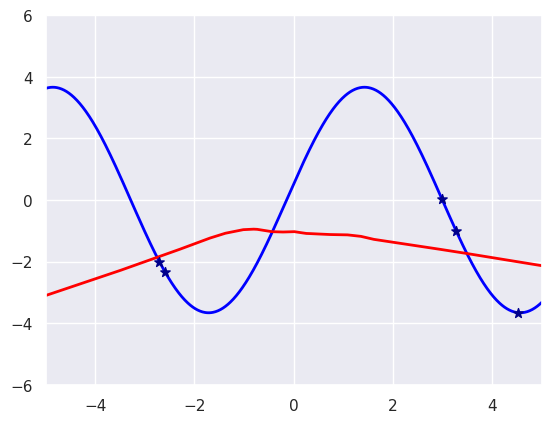

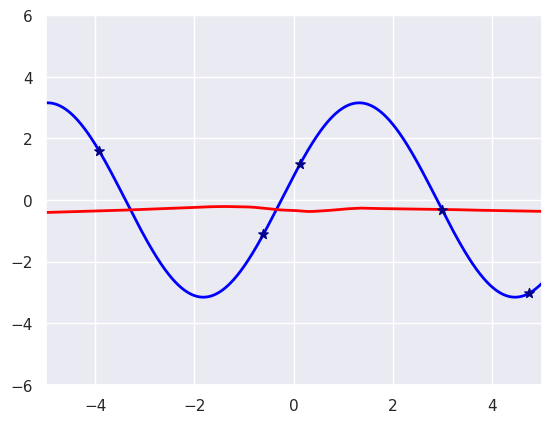

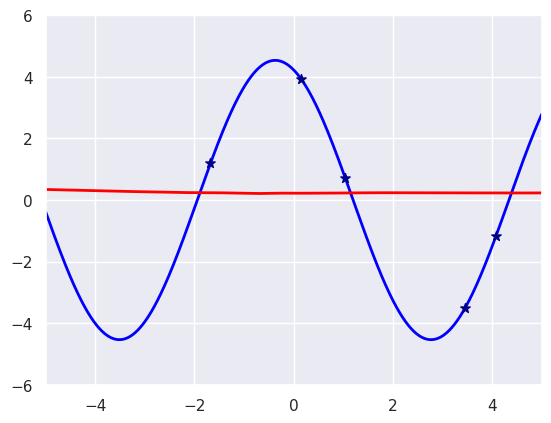

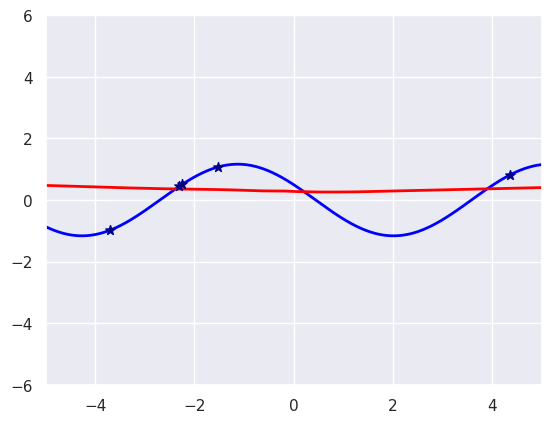

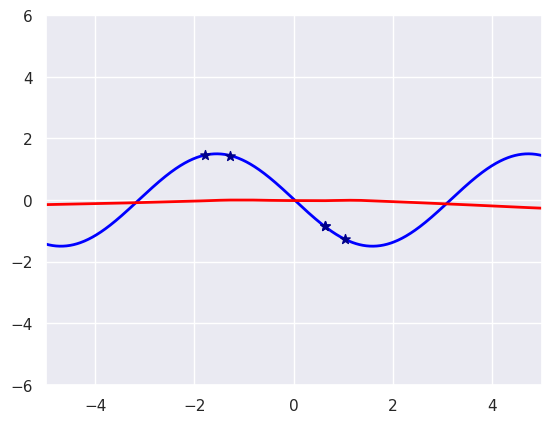

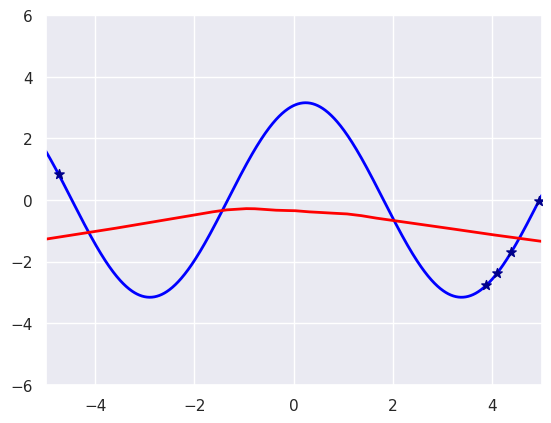

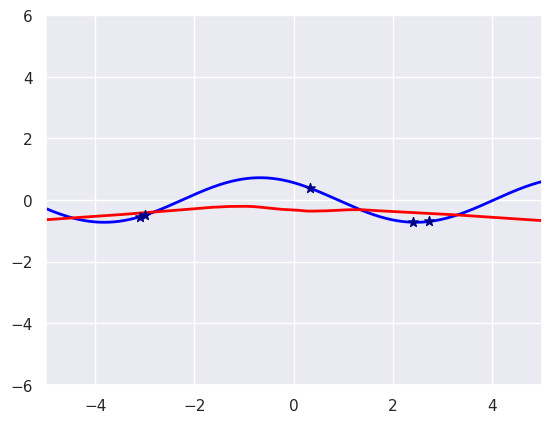

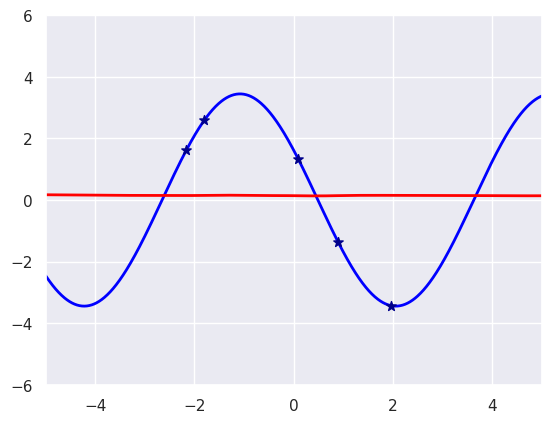

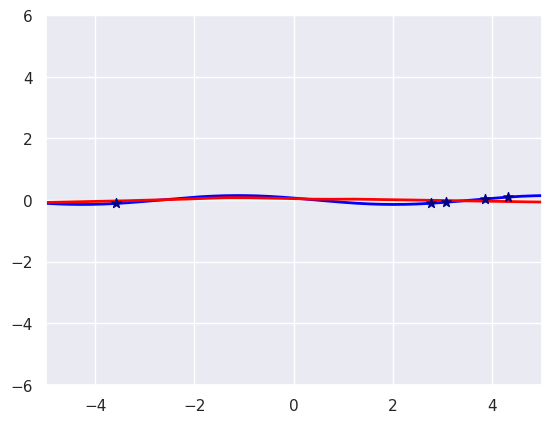

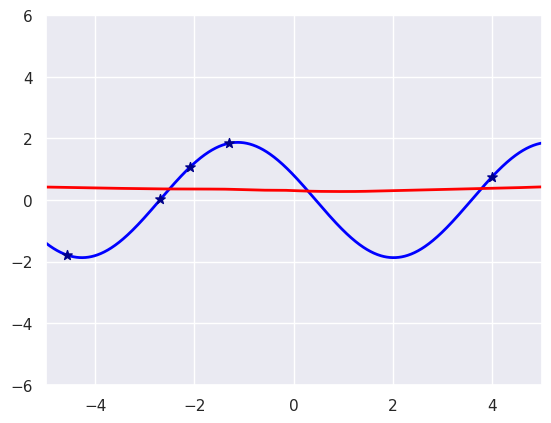

In [68]:
for _ in range(10):
    plot_sine()

## TRAIN

In [377]:
import time

likelihood.train()
gp.train()
net.train()

tot_iterations=5000

t = time.time_ns()

for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    inputs, labels = tasks.sample_task().sample_data(n_shot_train, noise=0.05)
    
    gp.set_train_data(inputs=inputs, targets=labels - net(inputs).reshape(-1))  
    predictions = gp(inputs)
    loss = -mll(predictions, gp.train_targets)
    loss.backward()
    optimizer.step()
    #---- print some stuff ----
    if(epoch%1000==0):
        mse = criterion(predictions.mean, labels)
        print(predictions.mean)
        print('[%d] - Loss: %.3f  MSE: %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp.likelihood.noise.item()
        ))

print(f"Total time : {(time.time_ns()-t)/1e9} s")

NameError: name 'likelihood' is not defined

## Test phase

In [10]:
tasks_test = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                phase_min=0.0, phase_max=np.pi, 
                                x_min=test_range[0], x_max=test_range[1], 
                                family="sine")

sample_task = tasks_test.sample_task()

-1.2500911
-1.2502369
-1.2506877
-1.2512392
-1.2500154
-1.2502383
-1.2499745
-1.2503195
-1.2500869
-1.2513479


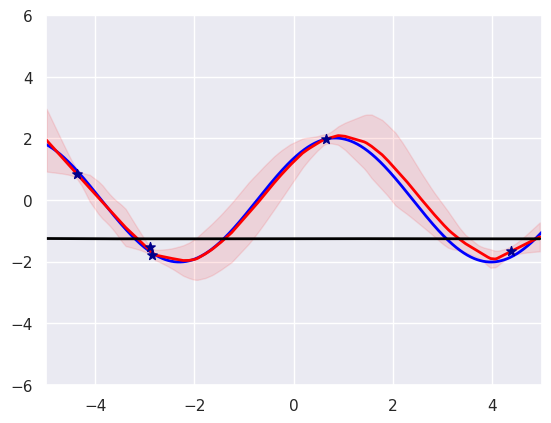

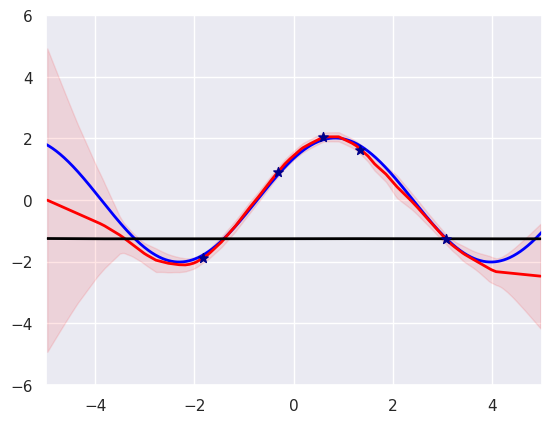

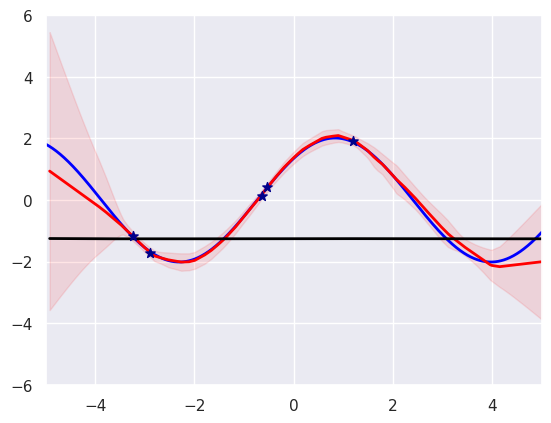

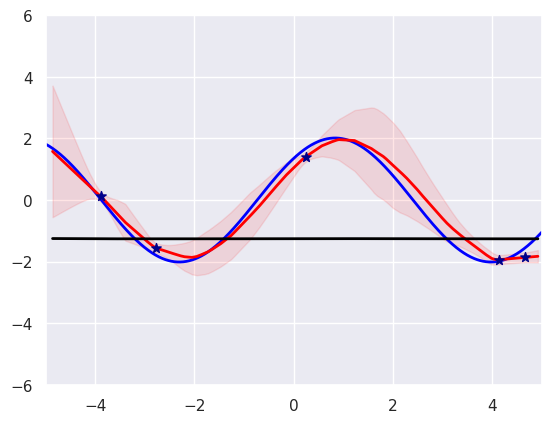

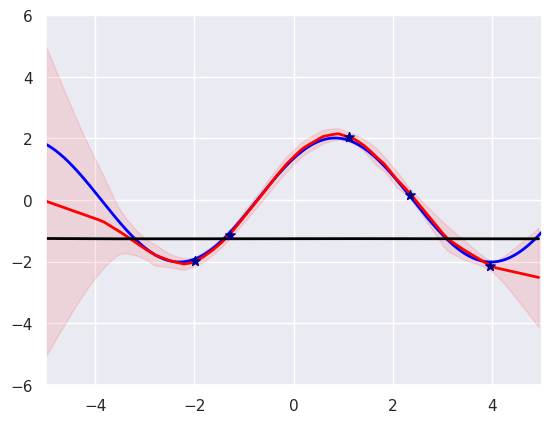

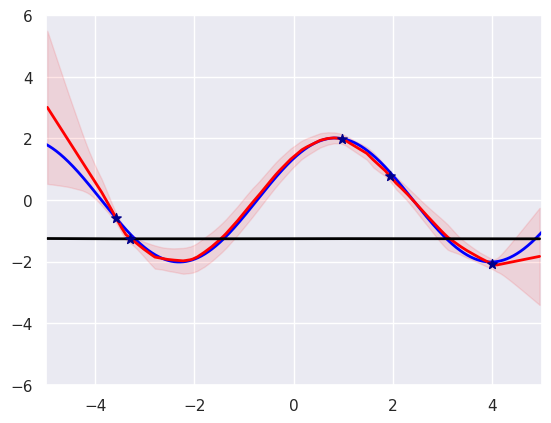

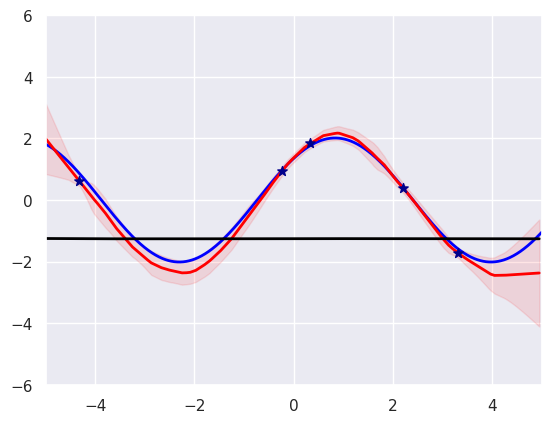

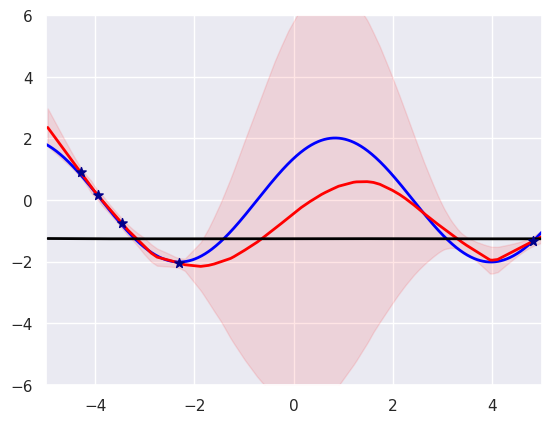

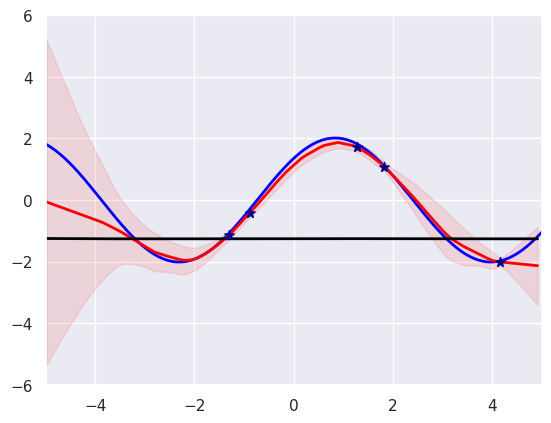

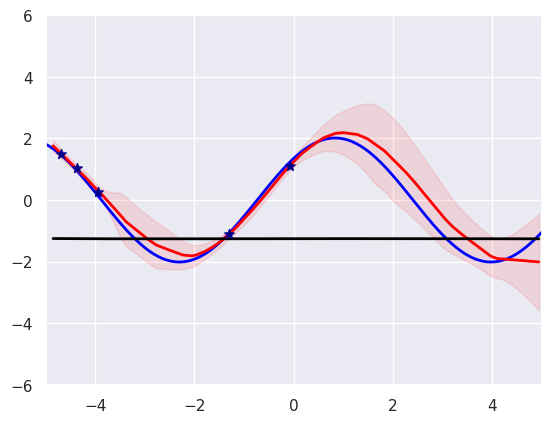

In [11]:
sample_size = 200

likelihood.eval()
net.eval()
gp.covar_module.eval()
# for param in net.parameters():
#     param.requires_grad_(False)
    
for i in range(10):
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp.eval()
            
    #Evaluation on all data
    mean = likelihood(gp(x_all)).mean + net(x_all).reshape(-1)
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += net(x_all).reshape(-1)
    upper += net(x_all).reshape(-1)
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)
    
    print(net(x_all).reshape(-1).detach().numpy()[0])
    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), net(x_all).reshape(-1).detach().numpy(), color='black', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

In [12]:
print("Test, please wait...")

likelihood.eval()
net.eval()
tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp.eval()

    #Evaluation on query set
    mean = likelihood(gp(x_query)).mean + net(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
-------------------
Average MSE: 0.40495814993418755 +- 0.8491715213674697
-------------------
